In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from joblib import dump
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [58]:
def plot_seasonal_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load for each season.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'Season' column to the DataFrame
    data['Month'] = data.index.month
    data['Season'] = data['Month'].apply(lambda x: (
        'Winter' if x in [12, 1, 2] else
        'Spring' if x in [3, 4, 5] else
        'Summer' if x in [6, 7, 8] else
        'Autumn'
    ))
    
    # Group by season and calculate the mean for actual and predicted values
    seasonal_data = data.groupby('Season').mean()
    
    # Plot the seasonal comparison
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_data.index, seasonal_data['Actual'], label='Actual Load', marker='o')
    plt.plot(seasonal_data.index, seasonal_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Season')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Season')
    plt.legend()
    plt.grid(True)
    plt.show()

In [59]:
def plot_monthly_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by month.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'Month' column to the DataFrame
    data['Month'] = data.index.month

    # Group by month and calculate the mean for actual and predicted values
    monthly_data = data.groupby('Month').mean()

    # Create month labels corresponding to the months present in the dataset
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    available_months = monthly_data.index
    available_labels = [month_labels[month - 1] for month in available_months]

    # Plot the monthly comparison
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data['Actual'], label='Actual Load', marker='o')
    plt.plot(monthly_data.index, monthly_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Month')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Month')
    plt.xticks(ticks=monthly_data.index, labels=available_labels)
    plt.legend()
    plt.grid(True)
    plt.show()

In [60]:
def plot_weekday_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by day of the week.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'DayOfWeek' column to the DataFrame
    data['DayOfWeek'] = data.index.dayofweek

    # Group by day of the week and calculate the mean for actual and predicted values
    weekday_data = data.groupby('DayOfWeek').mean()

    # Create day labels corresponding to the days of the week
    day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    available_days = weekday_data.index
    available_day_labels = [day_labels[day] for day in available_days]

    # Plot the weekday comparison
    plt.figure(figsize=(12, 6))
    plt.plot(weekday_data.index, weekday_data['Actual'], label='Actual Load', marker='o')
    plt.plot(weekday_data.index, weekday_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Day of the Week')
    plt.xticks(ticks=weekday_data.index, labels=available_day_labels)
    plt.legend()
    plt.grid(True)
    plt.show()


In [61]:
def plot_hourly_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by hour of the day.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add an 'Hour' column to the DataFrame
    data['Hour'] = data.index.hour

    # Group by hour of the day and calculate the mean for actual and predicted values
    hourly_data = data.groupby('Hour').mean()

    # Create hour labels corresponding to the hours of the day
    available_hours = hourly_data.index
    available_hour_labels = [f'{hour}:00' for hour in available_hours]

    # Plot the hourly comparison
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_data.index, hourly_data['Actual'], label='Actual Load', marker='o')
    plt.plot(hourly_data.index, hourly_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Hour of the Day')
    plt.xticks(ticks=hourly_data.index, labels=available_hour_labels)
    plt.legend()
    plt.grid(True)
    plt.show()

In [62]:
def plot_results_from_to(test_index, ys_test_rescaled, predictions_rescaled, start_date, end_date):
    """
    Plot the actual and forecasted load for a specified date range.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    - start_date: Start date for the plot.
    - end_date: End date for the plot.
    """
    # Convert start_date and end_date to datetime if they are strings
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)

    # Create a boolean mask for the date range
    mask = (test_index >= start_date) & (test_index <= end_date)

    # Apply the mask to the test data and predictions
    time_index = test_index[mask]
    ys_test_range = ys_test_rescaled[mask]
    predictions_range = predictions_rescaled[mask]

    # Plotting the actual and forecasted load for the specified date range
    plt.figure(figsize=(24, 5))
    plt.plot(time_index, ys_test_range.flatten(), label='Actual Load')
    plt.plot(time_index, predictions_range.flatten(), label='Forecasted Load')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title(f'Actual Load and Forecasted Load from {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}')
    plt.legend()

    # Customize x-axis to show date and day of the week
    plt.xticks(ticks=time_index[::24], labels=[f"{date:%Y-%m-%d}\n{date:%A}" for date in time_index[::24]], rotation=45)
    plt.show()


In [63]:

def plot_results(test_index, ys_test_rescaled, predictions_rescaled, hours_to_plot=720):
    """
    Plot the actual and forecasted load for the first month.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    - hours_in_month: Number of hours to plot for the first month.
    """
    # Adjust the test index to include only the first month of data
    time_index = test_index[:hours_to_plot]
    ys_test_first_month = ys_test_rescaled[:hours_to_plot]
    predictions_first_month = predictions_rescaled[:hours_to_plot]

    # Plotting the initial month of actual and forecasted load
    plt.figure(figsize=(24, 5))
    plt.plot(time_index, ys_test_first_month.flatten(), label='Actual Load')
    plt.plot(time_index, predictions_first_month.flatten(), label='Forecasted Load')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title('Actual Load and Forecasted Load for the First Month')
    plt.legend()

    # Customize x-axis to show date and day of the week
    plt.xticks(ticks=time_index[::24], labels=[f"{date:%Y-%m-%d}\n{date:%A}" for date in time_index[::24]], rotation=45)
    plt.show()


In [64]:
def build_and_train_model(xs_train, ys_train, model_config, num_target_features,path_to_save_model):
    """
    Build, train, and evaluate an LSTM model.

    Parameters:
    - xs_train, ys_train: Training data.
    - xs_test, ys_test: Test data.
    - model_config: Dictionary containing LSTM layers configuration and other model parameters.
    - scaler: Scaler used to scale data.
    - num_target_features: Number of output features for the model.

    Returns:
    - model: Trained LSTM model.
    - history: Training history of the model.
    - predictions_rescaled: Rescaled predictions.
    - ys_test_rescaled: Rescaled actual values.
    """

    # Determine the split index
    split_index = int(len(xs_train) * 0.8)  # 80% for training, 20% for validation

    # Split the data sequentially
    xs_train_split = xs_train[:split_index]
    ys_train_split = ys_train[:split_index]
    xs_val_split = xs_train[split_index:]
    ys_val_split = ys_train[split_index:]

    # Build the LSTM model
    model = Sequential()
    input_shape = (xs_train.shape[1], xs_train.shape[2])
    
    for layer_config in model_config['lstm_layers']:
        model.add(LSTM(layer_config['units'], return_sequences=layer_config['return_sequences'], input_shape=input_shape if 'input_shape' not in layer_config else None))

      # Reset input_shape after first layer
        input_shape = None

        # Add Dropout layer if specified
        if 'dropout' in layer_config:
            model.add(Dropout(layer_config['dropout']))
    model.add(Dense(num_target_features, activation='relu'))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    # Define the early stopping and model checkpoint callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(path_to_save_model, monitor='loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(xs_train_split, ys_train_split, epochs=model_config.get('epochs', 50), batch_size=model_config.get('batch_size', 32), validation_data=(xs_val_split, ys_val_split),  callbacks=[early_stopping, checkpoint])

    return model, history


In [65]:
def create_sequences(data, seq_length, forecast_horizon, target_col):
    target_col_index = target_col
    xs, ys = [], []
    target_col_name = data.columns[target_col_index]  
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data.iloc[i:(i + seq_length)].values
      #  x = data.iloc[i:(i + seq_length)].drop(columns=[target_col_name]).values 
        y = data.iloc[(i + seq_length):(i + seq_length + forecast_horizon), target_col].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [66]:
# Load and preprocess data
#data_df = pd.read_csv('../../data/processed/actuals_data.csv', parse_dates=['Time'], index_col='Time')
# Dataset with actual weather variables
# data_df = pd.read_csv('../data/interim/precovid-data/train/load_with_actual_weather_variables_dataset.csv', parse_dates=['Time'], index_col='Time')

# Dataset without COVID-19 with forecasted weather variables
train_data_df = pd.read_csv('../data/processed/covid-data/train/covid_dataset_actuals_train.csv', parse_dates=['Time'], index_col='Time')
# Corrected test data: 
test_data_df = pd.read_csv('../data/processed/covid-data/test/covid_dataset_corrected_weather_forecasts.csv', parse_dates=['Time'], index_col='Time')
#Forecasts: 
#test_data_df = pd.read_csv('../data/processed/covid-data/test/covid_dataset_forecasts_test.csv', parse_dates=['Time'], index_col='Time')
#Actuals:
#test_data_df = pd.read_csv('../data/processed/covid-data/test/covid_dataset_actuals_test.csv', parse_dates=['Time'], index_col='Time')


In [67]:
# Limit number of data to have same size as evalution period
EVALUATION_PERIOD_LENGTH = 744
test_data_df = test_data_df.iloc[:EVALUATION_PERIOD_LENGTH]

In [68]:
test_data_df.shape

(744, 6)

In [69]:
train_data_df.head()

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,
2017-03-18 00:00:00,16.764386,285.25,6.25375,0.000000,1.000000,1.031472e+06
2017-03-18 01:00:00,15.729386,285.00,9.20500,0.258819,0.965926,1.007206e+06
2017-03-18 02:00:00,15.816886,316.00,11.28375,0.500000,0.866025,9.861084e+05
2017-03-18 03:00:00,15.919386,327.00,7.16875,0.707107,0.707107,9.707610e+05
2017-03-18 04:00:00,15.769386,282.25,0.78000,0.866025,0.500000,9.622584e+05


In [70]:
test_data_df.head()

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,
2020-06-26 16:00:00,20.0,213,24.0,-0.866025,-5.000000e-01,1.156928e+06
2020-06-26 17:00:00,18.0,212,24.0,-0.965926,-2.588190e-01,1.124039e+06
2020-06-26 18:00:00,18.0,212,23.0,-1.000000,-1.836970e-16,1.073085e+06
2020-06-26 19:00:00,18.0,210,23.0,-0.965926,2.588190e-01,1.056702e+06
2020-06-26 20:00:00,18.0,208,22.0,-0.866025,5.000000e-01,1.048415e+06


In [71]:

load_col = train_data_df.pop('Load (kW)')
train_data_df['Load (kW)'] = load_col

target_col = (train_data_df.columns.get_loc('Load (kW)'))
num_target_features = 1
scaler_num_features = train_data_df.shape[1]

In [72]:
#1. Scale data
scaler = MinMaxScaler()
train_data_df_scaled = pd.DataFrame(scaler.fit_transform(train_data_df), columns=train_data_df.columns, index=train_data_df.index)
test_data_df_scaled = pd.DataFrame(scaler.fit_transform(test_data_df), columns=test_data_df.columns, index=test_data_df.index)

In [73]:
scaler.feature_names_in_

array(['Temperature (C)', 'Wind Direction (deg)', 'Wind Speed (kmh)',
       'hour_of_day_sin', 'hour_of_day_cos', 'Load (kW)'], dtype=object)

In [74]:
# Save the scaler to a file using joblib
#dump(scaler, '../models/scalers/scaler.joblib')

In [75]:

#2. Create sequences pairs of input and output
#In this case we have to configure the target_col-1 to be the index of the target column in the data_df in order to assign in the ys variable
# and have input output pairs of sequences
#seq_length = 2
seq_length = 1
forecast_horizon = 1
xs_train_scaled, ys_train_scaled = create_sequences(train_data_df_scaled, seq_length, forecast_horizon, target_col)
xs_test_scaled, ys_test_scaled = create_sequences(test_data_df_scaled, seq_length, forecast_horizon, target_col)

print(xs_train_scaled.shape, ys_train_scaled.shape)
print(xs_test_scaled.shape, ys_test_scaled.shape)

(28719, 1, 6) (28719, 1)
(743, 1, 6) (743, 1)


# Visualize the problem

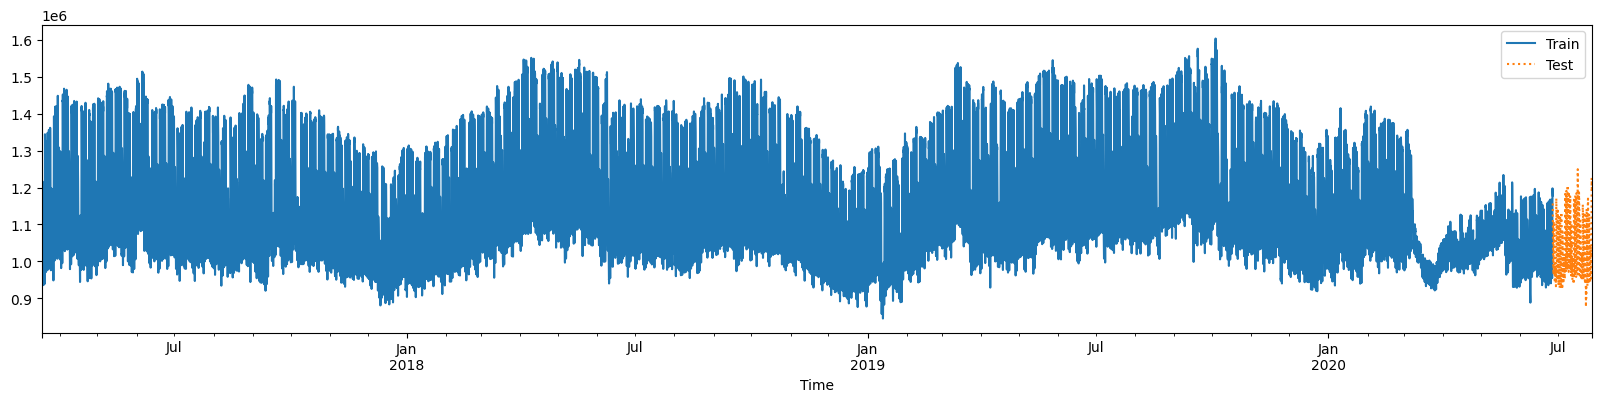

In [76]:
fig, ax = plt.subplots(figsize=(20, 4))
train_data_df['Load (kW)'].plot(ax=ax, label="Train")
test_data_df['Load (kW)'].plot(ax=ax, label="Test", linestyle='dotted')
ax.legend()

In [77]:
xs_train_scaled

array([[[0.49311621, 0.79818118, 0.1896225 , 0.5       , 1.        ,
         0.24540652]],

       [[0.46247224, 0.79748164, 0.27910855, 0.62940952, 0.98296291,
         0.21339019]],

       [[0.46506292, 0.88422525, 0.34213918, 0.75      , 0.9330127 ,
         0.18555483]],

       ...,

       [[0.65973353, 0.60405736, 0.59085052, 0.5       , 0.        ,
         0.45706947]],

       [[0.65751295, 0.61874781, 0.60851273, 0.37059048, 0.01703709,
         0.45408418]],

       [[0.67483346, 0.62609304, 0.65782292, 0.25      , 0.0669873 ,
         0.44936402]]])

In [78]:
ys_train_scaled

array([[0.21339019],
       [0.18555483],
       [0.16530561],
       ...,
       [0.45408418],
       [0.44936402],
       [0.4394038 ]])

In [79]:
#4. Define the model configuration
model_config = {
    'lstm_layers': [
       {'units': 64, 'return_sequences': True,'dropout': 0.2},
        {'units': 32, 'return_sequences': True,'dropout': 0.2},
        {'units': 16, 'return_sequences': False}
    ],
    'epochs': 60,
    'batch_size': 64
}

In [80]:
xs_train_scaled.shape

(28719, 1, 6)

In [81]:
xs_test_scaled.shape

(743, 1, 6)

In [82]:
ys_test_scaled.shape

(743, 1)

In [83]:
#5. Build, train, and evaluate the model
# multivariate_load_foreacasting_load_temp_included_model_path = '../models/multivariate_load_foreacasting_load_temp_included_model.keras'
# num_target_features = 1 # The number of output features for the model only load for now
# model, history = build_and_train_model(
#     xs_train, ys_train, model_config, num_target_features, path_to_save_model = multivariate_load_foreacasting_load_temp_included_model_path
# )
multivariate_load_foreacasting_load_temp_included_model_path = '../models/multivariate_load_foreacasting_load_temp_included_model.keras'
num_target_features = 1  # The number of output features for the model only load for now

# Define the number of experiments
num_experiments = 1

# Initialize variables to accumulate the total loss and track the best model
total_loss = 0
best_loss = float('inf')
best_model = None

model, history = build_and_train_model(
        xs_train_scaled, ys_train_scaled, model_config, num_target_features, path_to_save_model=multivariate_load_foreacasting_load_temp_included_model_path
    )
# for _ in range(num_experiments):
#     # Build and train the model
#     model, history = build_and_train_model(
#         xs_train_scaled, ys_train_scaled, model_config, num_target_features, path_to_save_model=multivariate_load_foreacasting_load_temp_included_model_path
#     )
    
#     # Evaluate the model
#     loss = model.evaluate(xs_test_scaled, ys_test_scaled, verbose=0)
#     total_loss += loss
    
#     # Update the best model if the current model's loss is lower than the best loss
#     if loss < best_loss:
#         best_loss = loss
#         best_model = model

# # Calculate the average loss
# average_loss = total_loss / num_experiments

# print(f'Average Test Loss over {num_experiments} experiments: {average_loss}')
# print(f'Best Loss: {best_loss}')

# # Save the best model
# best_model.save(multivariate_load_foreacasting_load_temp_included_model_path)
print(f'Best model saved to {multivariate_load_foreacasting_load_temp_included_model_path}')

Epoch 1/60


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


312/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0817
Epoch 1: loss improved from inf to 0.02910, saving model to ../models/multivariate_load_foreacasting_load_temp_included_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0749 - val_loss: 0.0025
Epoch 2/60
322/359 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0037
Epoch 2: loss improved from 0.02910 to 0.00309, saving model to ../models/multivariate_load_foreacasting_load_temp_included_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 9.4859e-04
Epoch 3/60
349/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 3: loss improved from 0.00309 to 0.00199, saving model to ../models/multivariate_load_foreacasting_load_temp_included_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 9.5642e-04
Epoch 4/60
315/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018
Epoch 4: loss improved from 0.00199 to 0.00172, saving model to ../models/multivariate_load_foreacasting

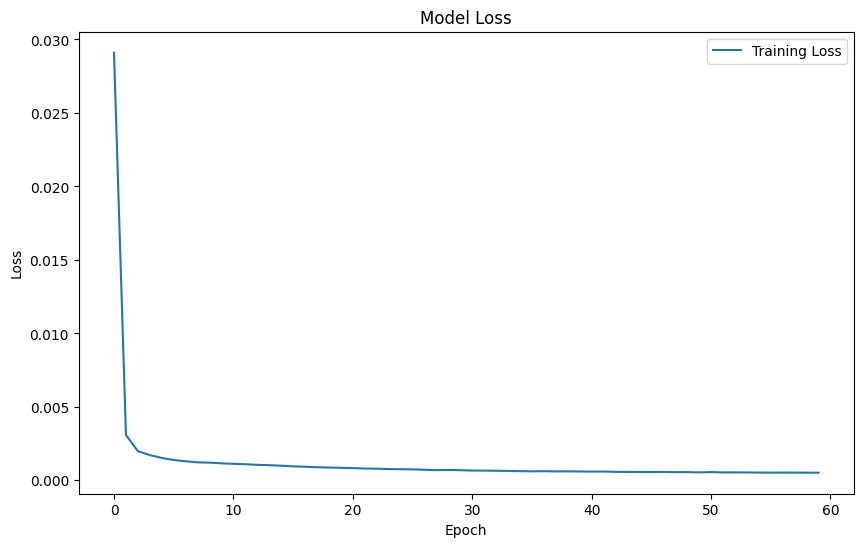

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

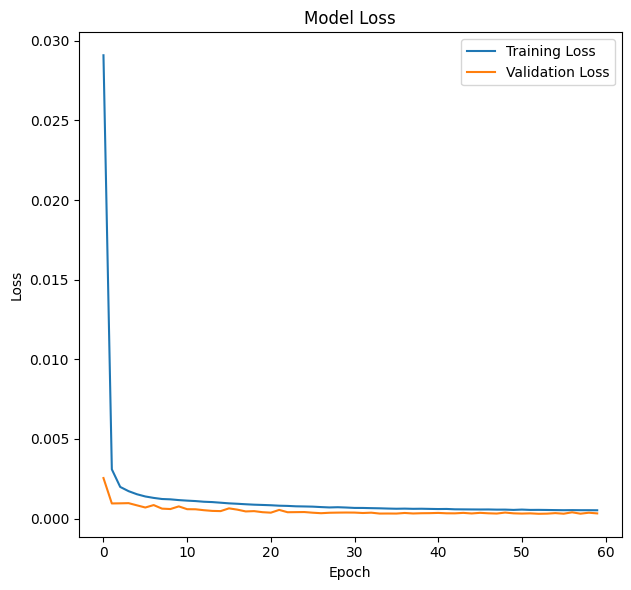

In [85]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [86]:
#     # Evaluate the model
loss = model.evaluate(xs_test_scaled, ys_test_scaled, verbose=0)
print(f'Test Loss: {loss}')

Test Loss: 0.0008072407799772918


In [87]:
# Load the best model from the path into model variable
model = tf.keras.models.load_model(multivariate_load_foreacasting_load_temp_included_model_path)
print('Best model loaded from path.')

Best model loaded from path.


In [88]:
xs_test_scaled.shape

(743, 1, 6)

In [89]:
#5. Build, train, and evaluate the model

# Make predictions on the test set
predictions_scaled = model.predict(xs_test_scaled) # contains only load
predictions_scaled

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[0.70452297],
       [0.604175  ],
       [0.48353618],
       [0.44570002],
       [0.42475107],
       [0.3944361 ],
       [0.37309426],
       [0.34400815],
       [0.30956352],
       [0.27900976],
       [0.26073214],
       [0.24539603],
       [0.25140256],
       [0.26933694],
       [0.2752713 ],
       [0.35766283],
       [0.50517225],
       [0.60819244],
       [0.6348425 ],
       [0.6159009 ],
       [0.61813223],
       [0.60899603],
       [0.5958618 ],
       [0.5515386 ],
       [0.50819683],
       [0.44908383],
       [0.41641268],
       [0.41331083],
       [0.4077447 ],
       [0.38598925],
       [0.35550696],
       [0.33073312],
       [0.30179778],
       [0.26310244],
       [0.24064322],
       [0.2137174 ],
       [0.19791417],
       [0.21484381],
       [0.20097518],
       [0.20662752],
       [0.25273335],
       [0.2840146 ],
       [0.30225584],
       [0.30355898],
       [0.29559803],
       [0.27576315],
       [0.273878  ],
       [0.264

In [90]:
predictions_scaled

array([[0.70452297],
       [0.604175  ],
       [0.48353618],
       [0.44570002],
       [0.42475107],
       [0.3944361 ],
       [0.37309426],
       [0.34400815],
       [0.30956352],
       [0.27900976],
       [0.26073214],
       [0.24539603],
       [0.25140256],
       [0.26933694],
       [0.2752713 ],
       [0.35766283],
       [0.50517225],
       [0.60819244],
       [0.6348425 ],
       [0.6159009 ],
       [0.61813223],
       [0.60899603],
       [0.5958618 ],
       [0.5515386 ],
       [0.50819683],
       [0.44908383],
       [0.41641268],
       [0.41331083],
       [0.4077447 ],
       [0.38598925],
       [0.35550696],
       [0.33073312],
       [0.30179778],
       [0.26310244],
       [0.24064322],
       [0.2137174 ],
       [0.19791417],
       [0.21484381],
       [0.20097518],
       [0.20662752],
       [0.25273335],
       [0.2840146 ],
       [0.30225584],
       [0.30355898],
       [0.29559803],
       [0.27576315],
       [0.273878  ],
       [0.264

In [91]:
# Rescale the predictions and actual values
# predictions=> contains values for target column (Load)
# but our scaler was trained on all columns so we have to inverse transform all columns
# so we need to padd with zeros the other columns
num_of_missing_training_features = train_data_df.shape[1] - num_target_features

padding_for_missing_training_features = np.zeros((predictions_scaled.shape[0], num_of_missing_training_features))
data_to_be_invert_from_scaling = np.hstack([padding_for_missing_training_features, predictions_scaled])
data_to_be_invert_from_scaling

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.70452297],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.60417497],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.48353618],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.88260651],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.86929858],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.84853315]])

In [92]:
data_to_be_invert_from_scaling

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.70452297],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.60417497],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.48353618],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.88260651],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.86929858],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.84853315]])

In [93]:
#Model outputs 
predictions= scaler.inverse_transform(data_to_be_invert_from_scaling)[:, target_col]
predictions

array([1139511.91271168, 1102108.71485561, 1057142.43114351,
       1043039.57312083, 1035231.17013283, 1023931.71906913,
       1015976.87450573, 1005135.46576319,  992296.7507824 ,
        980908.29949856,  974095.5948046 ,  968379.29128731,
        970618.13225926,  977302.90191388,  979514.84398006,
       1010225.04088308, 1065206.94859426, 1103606.16688696,
       1113539.57787689, 1106479.36770304, 1107311.07320504,
       1103905.69283999, 1099010.10309756, 1082489.29838033,
       1066334.31433828, 1044300.8390962 , 1032123.16069801,
       1030966.99096362, 1028892.303855  , 1020783.28629419,
       1009421.47286955, 1000187.40010464,  989402.18858047,
        974979.08750408,  966607.7514587 ,  956571.56032188,
        950681.14429206,  956991.41208427,  951822.09001226,
        953928.91362073,  971114.16518861,  982773.78276971,
        989572.92415005,  990058.64851671,  987091.32652423,
        979698.17643552,  978995.51680937,  975670.82760746,
        965015.5006407 ,

In [94]:
ys_test_scaled

array([[0.66301121],
       [0.5263068 ],
       [0.48235347],
       [0.46012031],
       [0.42843152],
       [0.41296562],
       [0.38396619],
       [0.34786972],
       [0.31302038],
       [0.28687776],
       [0.26027755],
       [0.25112096],
       [0.24835015],
       [0.23494428],
       [0.27933298],
       [0.38796582],
       [0.52428725],
       [0.60903253],
       [0.61815443],
       [0.62139401],
       [0.60632815],
       [0.59458943],
       [0.56315453],
       [0.53442569],
       [0.47700016],
       [0.44211708],
       [0.44116224],
       [0.43831461],
       [0.42235868],
       [0.39285253],
       [0.36920882],
       [0.33874723],
       [0.29639686],
       [0.26692842],
       [0.2291504 ],
       [0.20040768],
       [0.20238243],
       [0.17754293],
       [0.17646972],
       [0.21979557],
       [0.2583036 ],
       [0.2908557 ],
       [0.30594187],
       [0.3049359 ],
       [0.28579984],
       [0.27970261],
       [0.26406102],
       [0.220

In [95]:
xs_test_scaled.shape

(743, 1, 6)

In [96]:
padding_for_missing_training_features = np.zeros((ys_test_scaled.shape[0], num_of_missing_training_features))
ys_test_scaled = np.hstack([padding_for_missing_training_features, ys_test_scaled])
ys_test_scaled
ys_test = scaler.inverse_transform(ys_test_scaled)[:,target_col]

In [97]:
ys_test.shape

(743,)

In [98]:
ys_test

array([1124039.03213707, 1073084.53213707, 1056701.59413707,
       1048414.52013707, 1036603.00013707, 1030838.32013707,
       1020029.22013707, 1006574.80813707,  993585.24413707,
        983840.97813707,  973926.15213707,  970513.17013707,
        969480.39213707,  964483.56013707,  981028.77613707,
       1021520.02213707, 1072331.77413707, 1103919.29613707,
       1107319.34613707, 1108526.85013707, 1102911.27813707,
       1098535.85013707, 1086818.96413707, 1076110.72413707,
       1054706.22613707, 1041704.08813707, 1041348.18413707,
       1040286.77213707, 1034339.44013707, 1023341.47013707,
       1014528.63513707, 1003174.53813707,  987389.08013707,
        976405.16213707,  962323.97813707,  951610.56213707,
        952346.62213707,  943088.07413707,  942688.05213707,
        958837.10413707,  973190.39013707,  985323.69613707,
        990946.83813707,  990571.87813707,  983439.19813707,
        981166.54813707,  975336.38213707,  959231.08413707,
        961578.97413707,

In [99]:
(abs(ys_test-predictions)).sum()

5622551.45784709

In [100]:
predictions

array([1139511.91271168, 1102108.71485561, 1057142.43114351,
       1043039.57312083, 1035231.17013283, 1023931.71906913,
       1015976.87450573, 1005135.46576319,  992296.7507824 ,
        980908.29949856,  974095.5948046 ,  968379.29128731,
        970618.13225926,  977302.90191388,  979514.84398006,
       1010225.04088308, 1065206.94859426, 1103606.16688696,
       1113539.57787689, 1106479.36770304, 1107311.07320504,
       1103905.69283999, 1099010.10309756, 1082489.29838033,
       1066334.31433828, 1044300.8390962 , 1032123.16069801,
       1030966.99096362, 1028892.303855  , 1020783.28629419,
       1009421.47286955, 1000187.40010464,  989402.18858047,
        974979.08750408,  966607.7514587 ,  956571.56032188,
        950681.14429206,  956991.41208427,  951822.09001226,
        953928.91362073,  971114.16518861,  982773.78276971,
        989572.92415005,  990058.64851671,  987091.32652423,
        979698.17643552,  978995.51680937,  975670.82760746,
        965015.5006407 ,

In [101]:
predictions.shape

(743,)

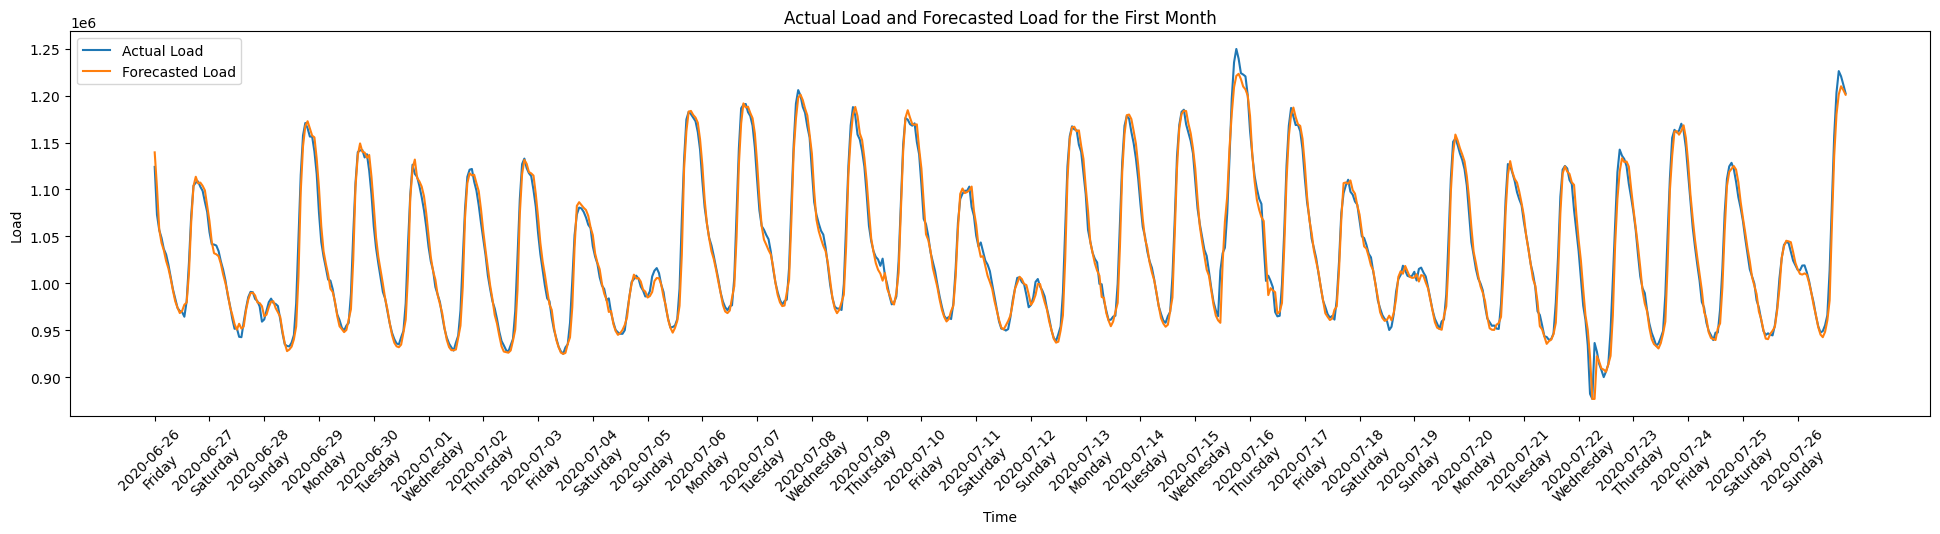

In [102]:
#6. Plot the results
test_index =test_data_df[seq_length:].index
hours_to_plot = -1# Approximately one month

plot_results(test_index, ys_test, predictions, hours_to_plot=hours_to_plot)

In [103]:
mae = mean_absolute_error(ys_test, predictions)
print(f"MAE: {mae}")

MAE: 7567.36400786957


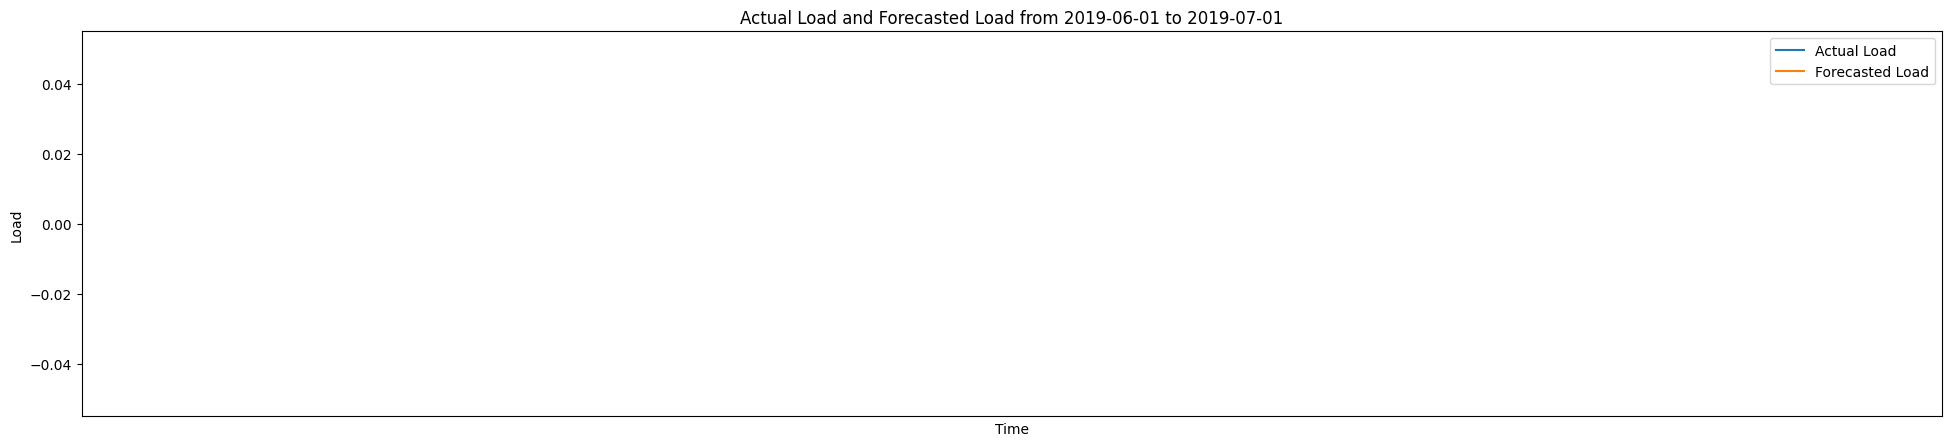

In [104]:
plot_results_from_to(test_index, ys_test, predictions,'2019-06-01', '2019-07-01')

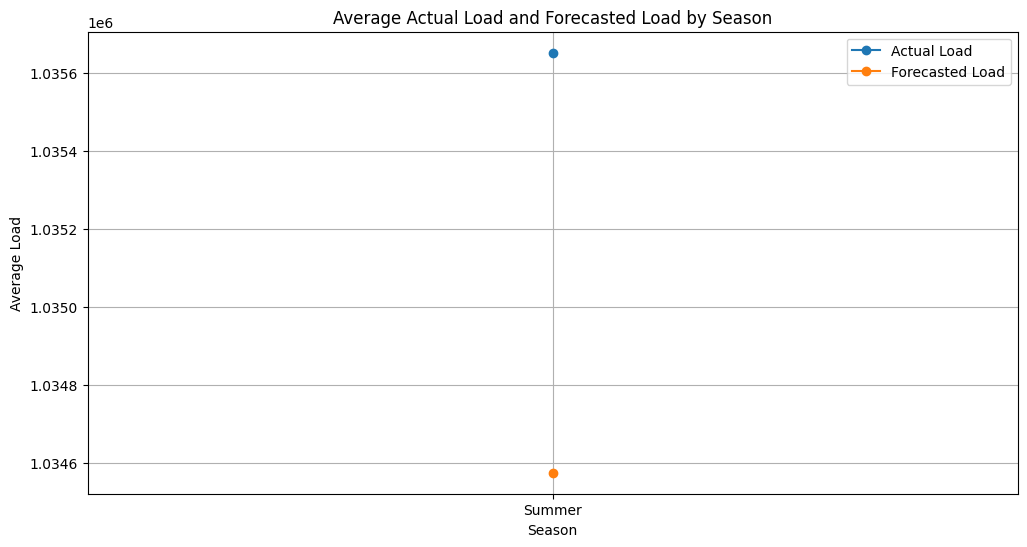

In [105]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_seasonal_comparison(test_index, ys_test, predictions)

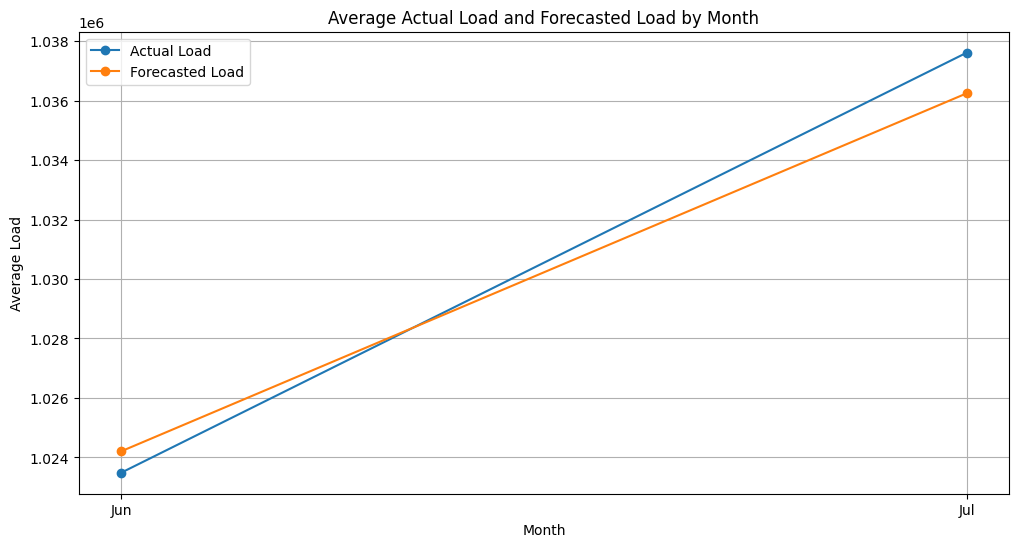

In [106]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_monthly_comparison(test_index, ys_test, predictions)

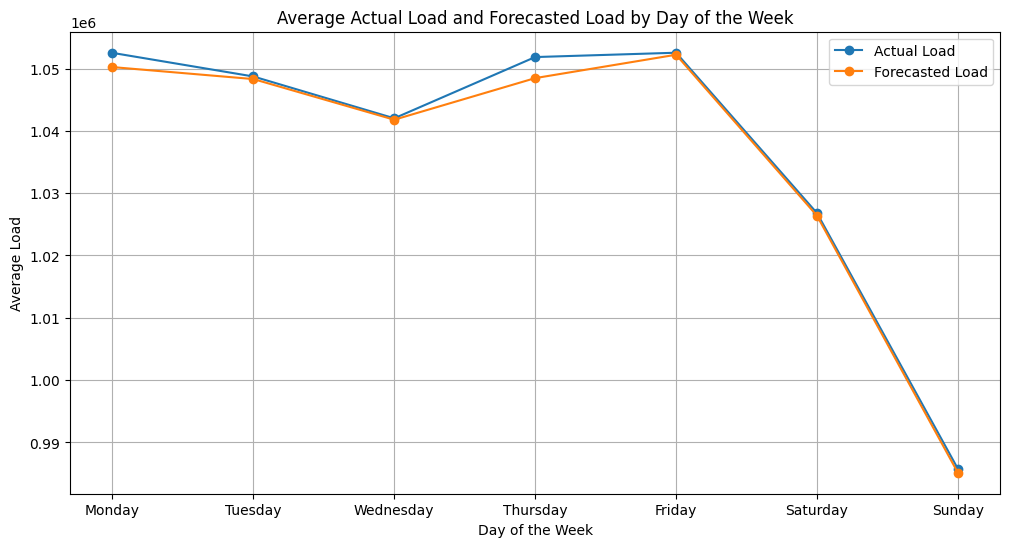

In [107]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_weekday_comparison(test_index, ys_test, predictions)

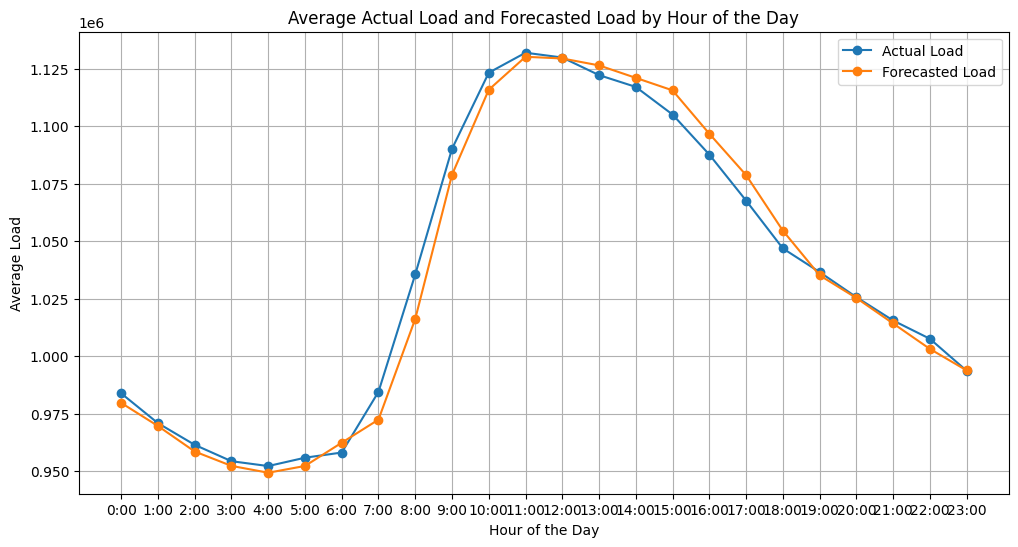

In [108]:
plot_hourly_comparison(test_index, ys_test, predictions)

In [109]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,237 (395.46 KB)

 Trainable params: 33,745 (131.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,492 (263.64 KB)

In [110]:
target_col_name = train_data_df.columns[target_col]
predictions_df = pd.DataFrame(predictions, columns=[target_col_name], index=test_index)
predictions_df

,Load (kW)
Time,
2020-06-26 17:00:00,1.139512e+06
2020-06-26 18:00:00,1.102109e+06
2020-06-26 19:00:00,1.057142e+06
2020-06-26 20:00:00,1.043040e+06
2020-06-26 21:00:00,1.035231e+06
...,...
2020-07-27 11:00:00,1.201229e+06
2020-07-27 12:00:00,1.209897e+06
2020-07-27 13:00:00,1.205890e+06


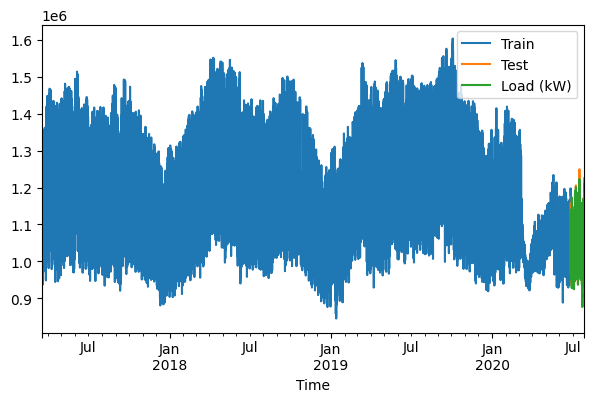

In [111]:
fig, ax = plt.subplots(figsize=(7, 4))
train_data_df['Load (kW)'].plot(ax=ax, label="Train")
test_data_df['Load (kW)'].plot(ax=ax, label="Test")
predictions_df.plot(ax=ax, label="Forecasted Load")
ax.legend()

In [112]:
actual = test_data_df['Load (kW)']
mape = np.mean(np.abs((actual[seq_length:] - predictions) / actual[seq_length:])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.72%
